# Impact of Order Latency

This example illustrates the impact of order latency on the performance of the strategy.

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
from numba import njit
import numpy as np

from numba.typed import Dict

from hftbacktest import (
    HftBacktest,
    NONE,
    NEW,
    GTX,
    BUY,
    SELL,
    ConstantLatency,
    FeedLatency,
    IntpOrderLatency,
    SquareProbQueueModel,
    Linear,
    Stat
)

@njit
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]

@njit
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

@njit
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2

@njit
def gridtrading_glft_mm(hbt, stat):
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + .5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    adj2 = 0.05

    order_qty = 1
    max_position = 20
    grid_num = 20
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                lambda_ = lambda_[:70] / 600
                x = ticks[:len(lambda_)]
                y = np.log(lambda_)
                k_, logA = linear_regression(x, y)
                A = np.exp(logA)
                k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
    
        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread = (c1 + 1 / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2
        
        bid_depth = half_spread + skew * hbt.position
        ask_depth = half_spread - skew * hbt.position
    
        # If the depth is invalid, set a large spread to prevent execution.
        if not np.isfinite(bid_depth):
            bid_depth = 1_000
        if not np.isfinite(ask_depth):
            ask_depth = 1_000

        bid_price = min(round(mid_price_tick - bid_depth), hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(round(mid_price_tick + ask_depth), hbt.best_ask_tick) * hbt.tick_size
        
        grid_interval = round(max(half_spread, 1)) * hbt.tick_size
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position:
            for i in range(grid_num):
                bid_price -= i * grid_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position:
            for i in range(grid_num):
                ask_price += i * grid_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)

## Order Latency from Feed Latency

Load data/ethusdt_20230401.npz
Load data/ethusdt_20230402.npz
Load data/ethusdt_20230403.npz
Load data/ethusdt_20230404.npz
Load data/ethusdt_20230405.npz
=========== Summary ===========
Sharpe ratio: 4.6
Sortino ratio: 3.3
Risk return ratio: 43.1
Annualised return: 119.45 %
Max. draw down: 2.77 %
The number of trades per day: 3212
Avg. daily trading volume: 3212
Avg. daily trading amount: 5886441
Max leverage: 3.40
Median leverage: 0.22


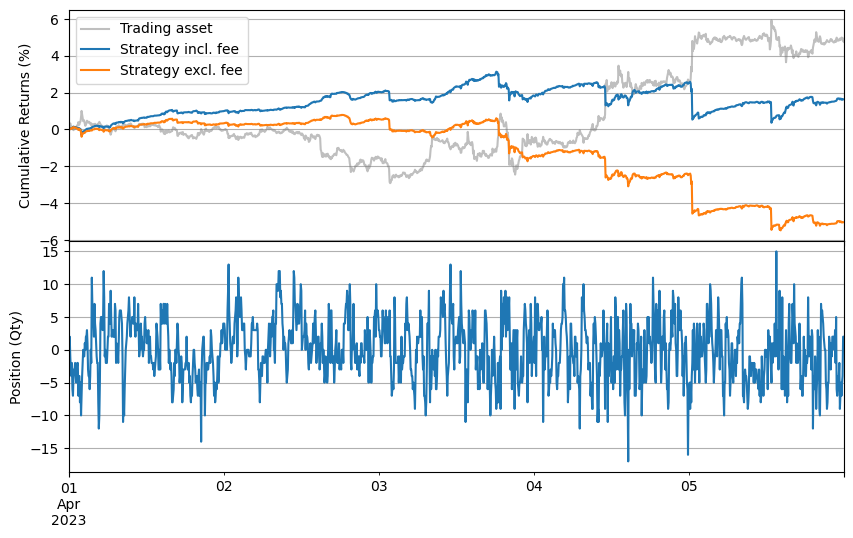

In [2]:
hbt = HftBacktest(
    [
        'data/ethusdt_20230401.npz',
        'data/ethusdt_20230402.npz',
        'data/ethusdt_20230403.npz',
        'data/ethusdt_20230404.npz',
        'data/ethusdt_20230405.npz',
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    snapshot='data/ethusdt_20230331_eod.npz',
    trade_list_size=10_000
)

stat = Stat(hbt)

gridtrading_glft_mm(hbt, stat.recorder)

stat.summary(capital=25_000)

## Historical Order Latency

Load data/ethusdt_20230401.npz
Load data/ethusdt_20230402.npz
Load data/ethusdt_20230403.npz
Load data/ethusdt_20230404.npz
Load data/ethusdt_20230405.npz
=========== Summary ===========
Sharpe ratio: 0.4
Sortino ratio: 0.3
Risk return ratio: 2.8
Annualised return: 11.03 %
Max. draw down: 4.00 %
The number of trades per day: 3493
Avg. daily trading volume: 3493
Avg. daily trading amount: 6401297
Max leverage: 2.47
Median leverage: 0.22


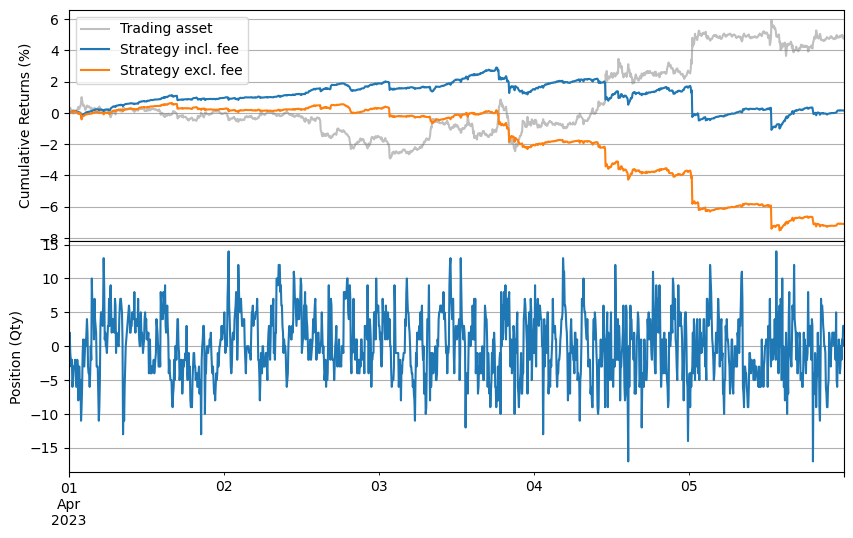

In [3]:
latency_data = np.concatenate(
    [np.load('../latency/ethusdt_{}_latency.npz'.format(date))['data'] for date in range(20230401, 20230406)]
)
    
hbt = HftBacktest(
    [
        'data/ethusdt_20230401.npz',
        'data/ethusdt_20230402.npz',
        'data/ethusdt_20230403.npz',
        'data/ethusdt_20230404.npz',
        'data/ethusdt_20230405.npz',
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=IntpOrderLatency(data=latency_data),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    snapshot='data/ethusdt_20230331_eod.npz',
    trade_list_size=10_000
)

stat = Stat(hbt)

gridtrading_glft_mm(hbt, stat.recorder)

stat.summary(capital=25_000)

## Order Latency from Amplified Feed Latency

Load data/ethusdt_20230401.npz
Load data/ethusdt_20230402.npz
Load data/ethusdt_20230403.npz
Load data/ethusdt_20230404.npz
Load data/ethusdt_20230405.npz
=========== Summary ===========
Sharpe ratio: 0.2
Sortino ratio: 0.2
Risk return ratio: 1.8
Annualised return: 6.66 %
Max. draw down: 3.61 %
The number of trades per day: 3193
Avg. daily trading volume: 3193
Avg. daily trading amount: 5849525
Max leverage: 4.57
Median leverage: 0.22


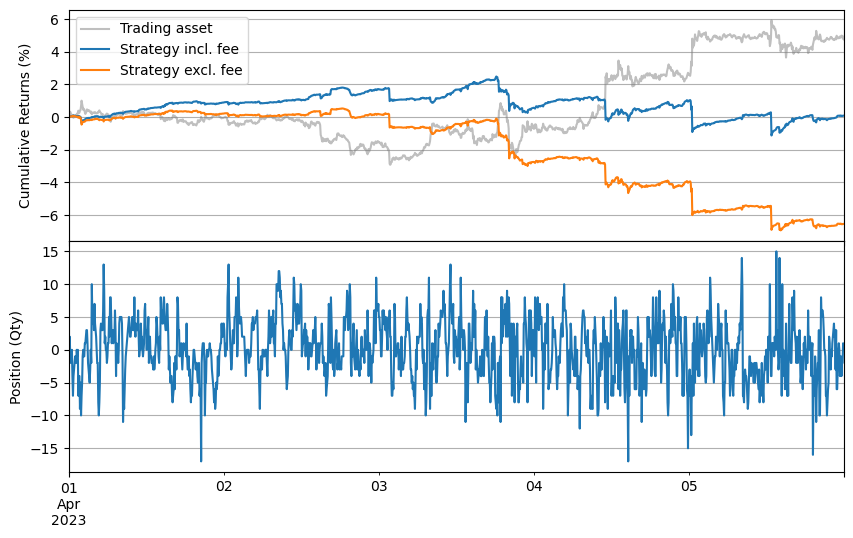

In [4]:
hbt = HftBacktest(
    [
        'data/ethusdt_20230401.npz',
        'data/ethusdt_20230402.npz',
        'data/ethusdt_20230403.npz',
        'data/ethusdt_20230404.npz',
        'data/ethusdt_20230405.npz',
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(entry_latency_mul=4, resp_latency_mul=3),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    snapshot='data/ethusdt_20230331_eod.npz',
    trade_list_size=10_000
)

stat = Stat(hbt)

gridtrading_glft_mm(hbt, stat.recorder)

stat.summary(capital=25_000)